This code solves arbitrary systems of linear equations using adiabatic quantum computing concepts.

References:

[1] https://arxiv.org/pdf/1805.10549

[2] https://arxiv.org/pdf/quant-ph/0001106

In [31]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
import numpy as np
import math
import time
from scipy.linalg import expm
import seaborn as sns
import matplotlib.pyplot as plt

from ProblemData import ProblemData

In [20]:
def check_matrix_format(A_matrix):
   # Extract the matrix from the Operator
    matrix = A_matrix.to_matrix()

    # Check if matrix is square
    assert matrix.shape[0] == matrix.shape[1], "Matrix must be square."

    # Check if matrix is unitary
    identity_matrix = np.eye(matrix.shape[0])
    assert np.allclose(identity_matrix, matrix @ matrix.T.conj()), "Matrix must be unitary."


Return the A(s) operator from equation 3 of [1]

In [21]:
def get_A_s(s, A):
    n_qubits = int(np.log2(len(A)))

    # Define Pauli matrices as NumPy arrays
    Z = Operator(np.array([[1, 0], [0, -1]]))
    X = Operator(np.array([[0, 1], [1, 0]]))
    I_n = Operator(np.eye(2 ** n_qubits))

    # Compute tensor products
    Z_tensor = Z.tensor(I_n)
    X_tensor = X.tensor(Operator(A))

    # Construct the A_s matrix
    A_s = (1 - s) * Z_tensor + s * X_tensor
    
    return A_s

Adiabatic solver function

In [24]:
def adiabatic_solver(A_matrix, b_vec, T, M, plot_evolution=False, verbose=False):
    # Normalize
    A_matrix = A_matrix / np.linalg.norm(A_matrix)
    b_vec = b_vec / np.linalg.norm(b_vec)
    
    # Set up matrices for Hamiltonian
    b_bar_plus = np.kron(np.array([1/math.sqrt(2), 1/math.sqrt(2)]), b_vec) # b vector with ancilla "+" qubit inserted at the beginning
    psi = np.kron(np.array([1/math.sqrt(2), -1/math.sqrt(2)]), b_vec) # set the initial state to be a "-" qubit and the b vector state, which is the eigenvector corresponding to the 0-eigenvalue of H(s) from equation 3 of [1] 
    P_b = np.eye(len(A_matrix) * 2) - np.outer(b_bar_plus, b_bar_plus) # the P_b operator from equation 3 of [1]
    A_B = get_A_s(0,A_matrix) # initial A(s) when s=0
    A_P = get_A_s(1,A_matrix) # final A(s) when s=1
    H_B = np.matmul(np.matmul(A_B, P_b), A_B) # initial Hamiltonian matrix
    H_P = np.matmul(np.matmul(A_P, P_b), A_P) # final Hamiltonian matrix

    # Initialize quantum circuit
    '''set the initial state to be a "-" qubit and the b vector state,
    which is the eigenvector corresponding to the 0-eigenvalue of H(s) from equation 3 of [1]'''
    n_qubits = int(np.log2(len(A_matrix))) + 1
    qc = QuantumCircuit(n_qubits)
    qc.initialize(psi, qc.qubits)
    
    # Define the time step
    dt = T / M

    # initialize data structures to store the system state as evolution progresses
    state_evolution = np.zeros((M, 2 ** n_bits), dtype=np.complex_)
    expected_state_evolution = np.zeros((M, 2 ** n_bits), dtype=np.complex_)
    eigenvector_error = np.zeros((M, 1), dtype=np.complex_)
    eigenvector_error_abs = np.zeros((M, 1), dtype=np.complex_)

    lastH = H_B
    U_T = np.eye(2 ** n_bits)
    dAds = (A_P - A_B) / M
    A = A_B
    eigenvalue_evolution = np.zeros((2 * len(A_matrix), M))

    # logarithmic f values so timestep gets smaller as evolution progresses
    f_vals = np.flip(M - np.logspace(0,math.log10(M),num=M))
    f_vals[M-1] = M

    psi = Statevector.from_label('0' * n_bits)

    for l in range(M):
        s = f_vals[l] / M
        A = A_B + s * (A_P - A_B)
        H = np.matmul(np.matmul(A, P_b), A)
        
        # using equation 5.4 in [2]
        U = expm(-1j * dt * H)
        U_T = np.matmul(U, U_T)
        psi = Statevector(U.dot(psi.data))
        state_evolution[l, :] = psi.data

        # Add to circuit
        U_gate = UnitaryGate(U)
        qc.append(U_gate, qc.qubits)

        # expected state evolution to check answers
        if plot_evolution:
            H_eig, eigenvectors = np.linalg.eig(H)
            min_eig_id = np.argmin(H_eig)
            if eigenvectors[0, min_eig_id].real < 0:
                eigenvectors = eigenvectors * -1
            expected_state_evolution[l, :] = eigenvectors[:, min_eig_id]
            eigenvalue_evolution[:, l] = np.sort(H_eig)
            eigenvector_error[l] = np.linalg.norm(psi.data - expected_state_evolution[l, :])
            eigenvector_error_abs[l] = np.linalg.norm(np.abs(psi.data) - np.abs(expected_state_evolution[l, :]))

        # keep real part of first element of the eigenvector positive as convention to avoid it flipping signs randomly
        if psi.data[0].real < 0:
            psi = psi * -1
        if(l % 100 == 0):
            print("l = ", l)
        if (verbose and l % 100 == 0):
            print(", delta-t * delta-H = ", np.linalg.norm(dt * (lastH - H)), ", 1/M = ", 1/M)
            print(" psi = ", np.round(psi, decimals=8))
            print("expected psi: ", expected_state_evolution[l,:])
            print("psi error: ", psi - expected_state_evolution[l,:])
        
        lastH = H

        state_evolution[l, :] = psi.data
    
    # Simulate the circuit
    simulator = Aer.get_backend('aer_simulator')
    qc.save_statevector()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()
    final_state = result.get_statevector(qc)

    # Plotting the results
    if plot_evolution:
        plot_histogram(final_state.probabilities_dict())

    return final_state
    

Use PrpblemData class to create a linear system corresponding to a neutron transport equation discretization

real answer (scaled):
[0.07268108 0.09791757 0.1030929  0.08964646 0.08964646 0.1030929
 0.09791757 0.07268108 0.09791757 0.16421758 0.17039745 0.11853306
 0.11853306 0.17039745 0.16421758 0.09791757 0.1030929  0.17039745
 0.17705097 0.12518853 0.12518853 0.17705097 0.17039745 0.1030929
 0.08964646 0.11853306 0.12518853 0.11127869 0.11127869 0.12518853
 0.11853306 0.08964646 0.08964646 0.11853306 0.12518853 0.11127869
 0.11127869 0.12518853 0.11853306 0.08964646 0.1030929  0.17039745
 0.17705097 0.12518853 0.12518853 0.17705097 0.17039745 0.1030929
 0.09791757 0.16421758 0.17039745 0.11853306 0.11853306 0.17039745
 0.16421758 0.09791757 0.07268108 0.09791757 0.1030929  0.08964646
 0.08964646 0.1030929  0.09791757 0.07268108]
l =  0
l =  100
l =  200
l =  300
l =  400
l =  500
l =  600
l =  700
l =  800
l =  900


/tmp/ipykernel_23432/2563527248.py:35: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  psi_temp = psi_temp[0:int(len(psi)/2)]


T:  1000000
M:  1000
psi:  Statevector([0.05950875+0.00404593j, 0.07778657-0.00052468j,
             0.08230976-0.0009112j , 0.07421018+0.00357035j,
             0.07421018+0.00357035j, 0.08230976-0.0009112j ,
             0.07778657-0.00052468j, 0.05950875+0.00404593j,
             0.07778657-0.00052468j, 0.11879885-0.00338394j,
             0.12301332-0.00282712j, 0.09327354+0.00094271j,
             0.09327354+0.00094271j, 0.12301332-0.00282712j,
             0.11879885-0.00338394j, 0.07778657-0.00052468j,
             0.08230976-0.0009112j , 0.12301332-0.00282712j,
             0.12757606-0.00194335j, 0.09897556+0.00120504j,
             0.09897556+0.00120504j, 0.12757606-0.00194335j,
             0.12301332-0.00282712j, 0.08230976-0.0009112j ,
             0.07421018+0.00357035j, 0.09327354+0.00094271j,
             0.09897556+0.00120504j, 0.09275536+0.00436748j,
             0.09275536+0.00436748j, 0.09897556+0.00120504j,
             0.09327354+0.00094271j, 0.07421018+0.00357035

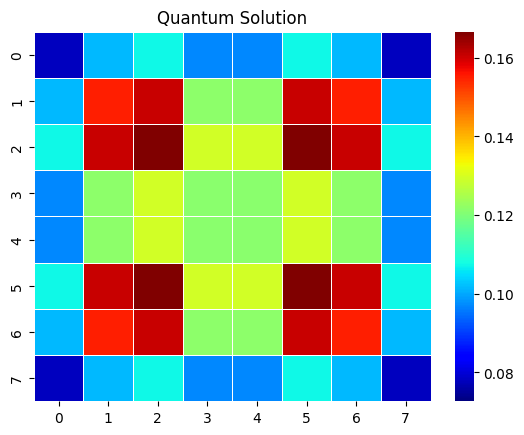

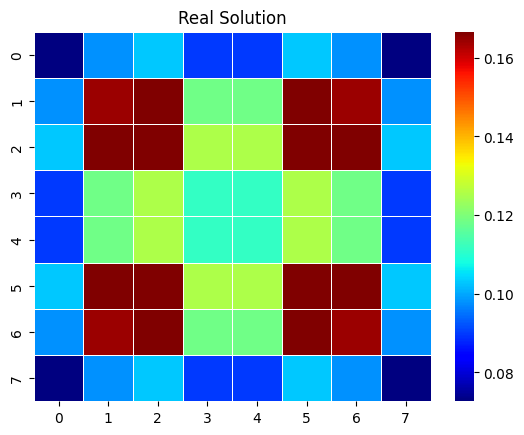

<Figure size 640x480 with 0 Axes>

In [32]:
data = ProblemData("input.txt")

# Create the vectors holding the material data at each discretized point
data.read_input("input.txt")
data.initialize_BC()
data.initialize_XSs() 

# make A matrix and b vector
if data.sim_method == "sp3":
    A_mat_size = 2 * (data.n_x) * (data.n_y)
    A_matrix, b_vec = data.sp3_construct_A_matrix(A_mat_size) 
elif data.sim_method == "diffusion":
    A_mat_size = (data.n_x) * (data.n_y)
    A_matrix, b_vec = data.diffusion_construct_A_matrix(A_mat_size)

# Input which T and M values to test
T_vec = [1000000]
M_vec = [1000]
n_bits = 1 + int(math.log2(len(A_matrix)))

# Real answer to linear system
print("real answer (scaled):")
real_psi_solution = np.linalg.inv(A_matrix).dot(b_vec)
real_psi_solution = real_psi_solution/np.linalg.norm(real_psi_solution)
print(real_psi_solution)

# Parametric solutions, run solver for many M and T values
psi_solutions = np.zeros((len(T_vec), len(M_vec), len(A_matrix)), dtype=np.complex128)
psi_error = np.zeros((len(T_vec), len(M_vec), len(A_matrix)), dtype=np.complex128)
time1 = time.perf_counter()
for i, T in enumerate(T_vec):
    for j, M in enumerate(M_vec):
        psi = adiabatic_solver(A_matrix, b_vec, T, M, plot_evolution=False, verbose=False)
        psi_temp = psi.data
        psi_temp = psi_temp[0:int(len(psi)/2)]
        psi_temp = psi_temp / np.linalg.norm(psi_temp)
        psi_solutions[i,j,:] = psi_temp
        psi_error[i,j,:] = psi_temp - real_psi_solution

        print("T: ", T)
        print("M: ", M)
        print("psi: ", psi)
        print("psi absolute value: ", np.abs(psi))
        print("real psi: ", real_psi_solution)
        print("psi error: ", psi_temp - real_psi_solution)
time2 = time.perf_counter()
print("solver run time: ", time2 - time1)


# plot parametric results
psi = psi_temp.reshape((data.n_x, data.n_y))

min_val = min(np.min(np.abs(psi)), np.min(real_psi_solution))
max_val = min(np.max(np.abs(psi)), np.max(real_psi_solution))

ax = sns.heatmap(np.abs(psi), linewidth=0.5, cmap="jet", vmin=min_val, vmax=max_val)
plt.title("Quantum Solution")
plt.savefig('q_sol.png')
plt.figure()

real_psi_solution = real_psi_solution.reshape((data.n_x, data.n_y))
ax = sns.heatmap(real_psi_solution, linewidth=0.5, cmap="jet", vmin=min_val, vmax=max_val)
plt.title("Real Solution")
plt.savefig('real_sol.png')
plt.figure()
plt.show()